<a href="https://colab.research.google.com/github/nanmaharaj/FMML_Project_and_Labs/blob/main/Module_01_Lab_03_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255 #normalizing the pixel values of the images. By dividing each pixel value by 255, you're scaling the pixel values to be in the range [0, 1].
test_X = test_X/255 #This is a common preprocessing step when working with image data, as it helps the model converge faster during training.

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

11490434/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We **should not** also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

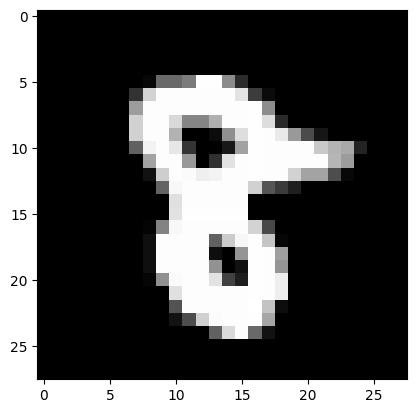

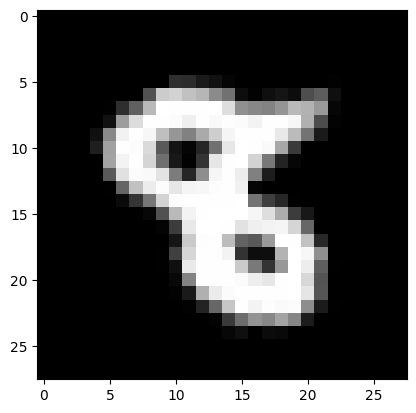

In [5]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample

  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional

  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained

  nsample = sample.copy() # preallocate the augmented array to make it faster

  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])

  return np.squeeze(nsample) # take care if the input had only one sample.

The code is making the sample 3-dimensional to ensure compatibility with the subsequent operations, specifically with the rotation process and to handle both single images and collections of images consistently. Let's break down why this is done:

**Handling Single Images:** In computer vision and image processing, a single image is often represented as a 2D array (a matrix) where the two dimensions correspond to the height and width of the image. However, when working with multiple images or batches of images, it's common to represent them as 3D arrays where the third dimension typically corresponds to the color channels (e.g., Red, Green, Blue). This 3D representation allows for batch processing.

**Consistency:** By ensuring that the sample is 3D, the code can consistently treat both single images and collections of images in the same way. This is especially important when you want to apply data augmentation to a single image or to multiple images simultaneously.

**Rotation Function Compatibility:** The code uses the rotate function to apply rotation to the images. This function is typically designed to work with 3D arrays where the third dimension represents the color channels. By making sample 3D, the code ensures that the rotation function can handle the input correctly, even if the input is a single image (where the third dimension would typically be 1).

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

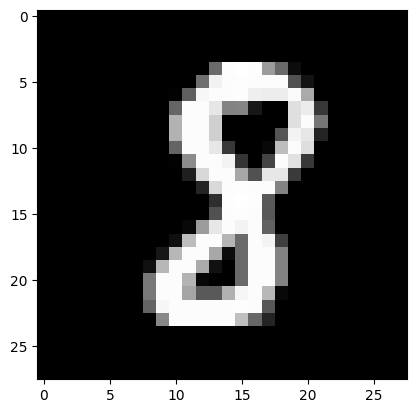

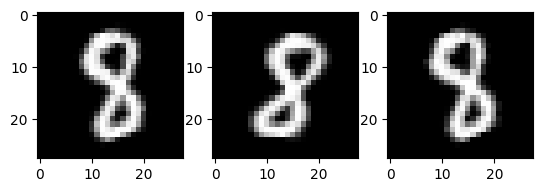

In [7]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [22]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6634


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [24]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here
naugmentations = 5

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-24-857e5657ce5c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6659
Accuracy after rotation augmentation constrained by  20  is  0.6748
Accuracy after rotation augmentation constrained by  30  is  0.6796
Accuracy after rotation augmentation constrained by  40  is  0.6841
Accuracy after rotation augmentation constrained by  50  is  0.6626
Accuracy after rotation augmentation constrained by  60  is  0.6651
Accuracy after rotation augmentation constrained by  70  is  0.6549
Accuracy after rotation augmentation constrained by  80  is  0.6658
Accuracy after rotation augmentation constrained by  90  is  0.643


In [35]:
naugmentations = 10
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies1 = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies1[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-35-000a61649882>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies1 = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6771
Accuracy after rotation augmentation constrained by  20  is  0.6786
Accuracy after rotation augmentation constrained by  30  is  0.6868
Accuracy after rotation augmentation constrained by  40  is  0.6836
Accuracy after rotation augmentation constrained by  50  is  0.6829
Accuracy after rotation augmentation constrained by  60  is  0.6758
Accuracy after rotation augmentation constrained by  70  is  0.6673
Accuracy after rotation augmentation constrained by  80  is  0.6658
Accuracy after rotation augmentation constrained by  90  is  0.6683


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

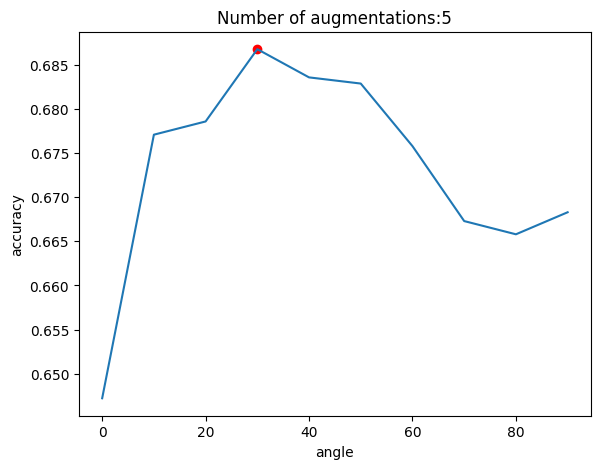

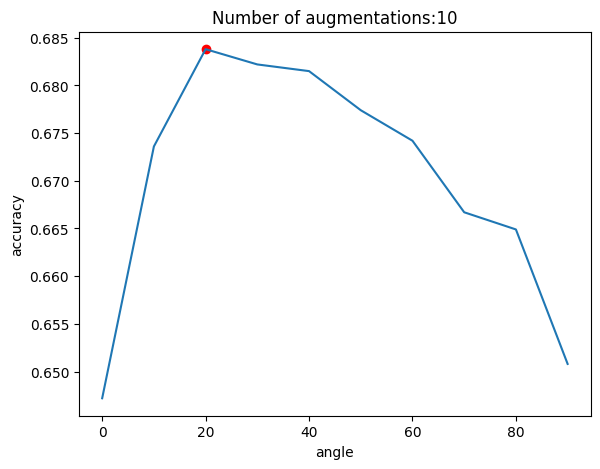

In [36]:

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy

ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
plt.title('Number of augmentations:5')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')


fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies1)

ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
plt.title('Number of augmentations:10')
# plot the maximum accuracy
maxind = np.argmax(accuracies1)
plt.scatter(angleconstraints[maxind], accuracies1[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [38]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

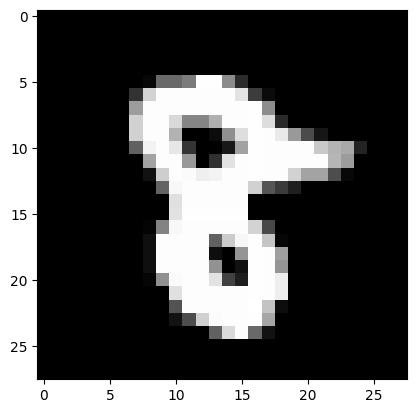

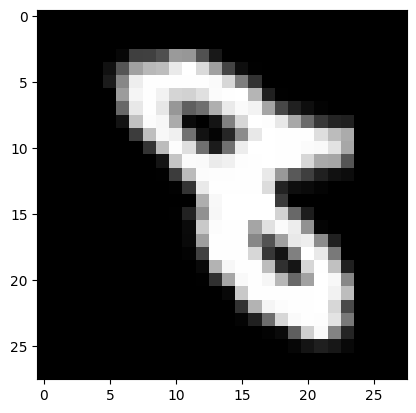

In [39]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [40]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [46]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

naugmentations=5

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-46-d9ef9bed364c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6256
Accuracy after shear augmentation constrained by  0.4  is  0.6382
Accuracy after shear augmentation constrained by  0.6  is  0.6545
Accuracy after shear augmentation constrained by  0.8  is  0.6534
Accuracy after shear augmentation constrained by  1.0  is  0.6576
Accuracy after shear augmentation constrained by  1.2  is  0.6347
Accuracy after shear augmentation constrained by  1.4  is  0.6436
Accuracy after shear augmentation constrained by  1.6  is  0.6138
Accuracy after shear augmentation constrained by  1.8  is  0.6189
Accuracy after shear augmentation constrained by  2.0  is  0.6007


In [47]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies1 = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

naugmentations=10

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies1[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies1[ii], flush=True)

<ipython-input-47-c158d81264fa>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies1 = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6188
Accuracy after shear augmentation constrained by  0.4  is  0.6322
Accuracy after shear augmentation constrained by  0.6  is  0.6457
Accuracy after shear augmentation constrained by  0.8  is  0.6671
Accuracy after shear augmentation constrained by  1.0  is  0.6621
Accuracy after shear augmentation constrained by  1.2  is  0.6545
Accuracy after shear augmentation constrained by  1.4  is  0.6472
Accuracy after shear augmentation constrained by  1.6  is  0.6382
Accuracy after shear augmentation constrained by  1.8  is  0.6367
Accuracy after shear augmentation constrained by  2.0  is  0.604


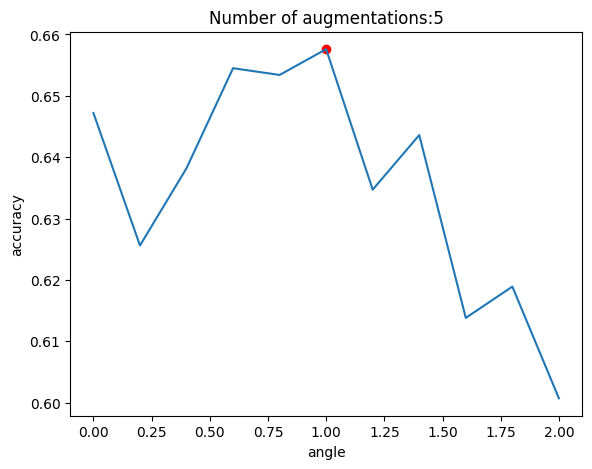

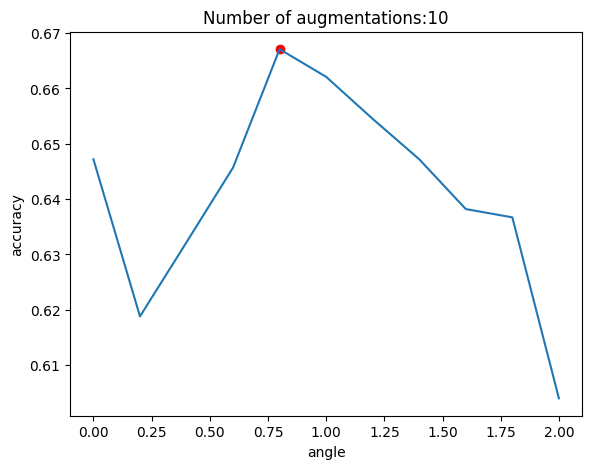

In [48]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
plt.title('Number of augmentations:5')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies1)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
plt.title('Number of augmentations:10')
# plot the maximum accuracy
maxind = np.argmax(accuracies1)
plt.scatter(shearconstraints[maxind], accuracies1[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [16]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [17]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-17-09de780976d0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6151
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5997
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5915
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6198
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6031
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5916
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.634
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.5991
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6044
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6358
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5827
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.579
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.5877
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6344
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.61

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

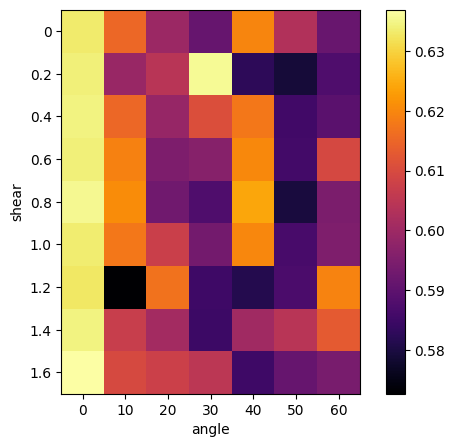

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

**ANSWERS**:
1)Accuracy after augmentation shear: 0.8 angle: 0.0  is **0.6354** is the best value I got. The value hasn't really improved since the baseline accuracy without augmentation is  0.6472.\
2)As shown above on increasing the number of augmentations, for rotation and shear transformation, from 5 to 10 we see an **increase** in the accuracy.\
3)\
4)

Text(0.5, 1.0, 'Random Noise')

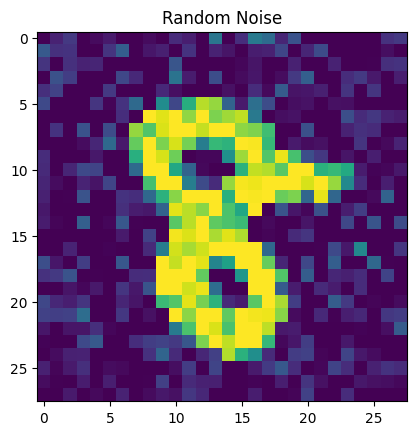

In [51]:
from skimage.util import random_noise
#standard deviation for noise to be added in the image
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(sample,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise')

<ipython-input-52-64880b091e22>:2: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred = gaussian(sample,sigma=1,multichannel=True)


Text(0.5, 1.0, 'Blurred Image')

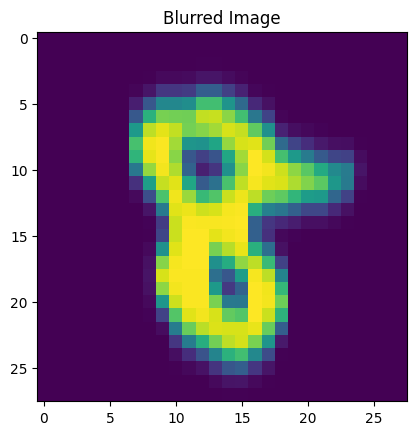

In [52]:
from skimage.filters import gaussian
blurred = gaussian(sample,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')

QUIZ NOTES:

1) What is the primary purpose of data augmentation in machine learning?\
A) To increase the size of the dataset


2) Data augmentation helps in making the model:\
A)More robust to variations in the input data



3) Which of the following is NOT a common data augmentation technique used in image classification tasks?\
A) Dropout(Rotation,Scaling,Flipping are True)


4) When applying data augmentation, it is essential to ensure that:\
A)The augmented data maintains the same labels as the original data


5) Which of the following is a commonly recognized BAD practice when applying data augmentation in machine learning?\
[options:a)Applying augmentations that distort the original data's semantic meaning b)Using a diverse set of augmentation techniques c)Applying augmentation to improve data variability d)Consistently using the same augmentation for all classes]\
answer) option d


{When applying data augmentation in machine learning, it is crucial to ensure that the augmented data maintains the same labels as the original data. This means that the augmented versions of the input data should be generated in a way that preserves their corresponding ground truth labels. This ensures that the augmented data can be used for model training, and the labels are consistent with the original dataset, allowing the model to learn from the augmented examples while still understanding the correct labels associated with them.

Option (a) "Applying augmentations that distort the original data's semantic meaning" is not necessarily a bad practice in all cases. While it's true that some data augmentation techniques may introduce distortions or changes in the data, these distortions can be beneficial if they help the model generalize better. For example, in image classification tasks, flipping, rotation, and cropping can change the orientation or position of objects in the image, but they can still be valuable for training the model to recognize objects under various conditions.

The appropriateness of a data augmentation technique depends on the specific problem and the desired outcomes. Some degree of distortion or variation in the data may be essential for robust model training, as long as it doesn't compromise the overall quality of the data or the interpretability of the results. Therefore, option (a) is not inherently a bad practice, and its suitability depends on the context of the problem. On the other hand, option (d) is generally considered a bad practice because it can hinder the model's ability to learn diverse patterns from the data.}
